In [3]:
%pip install requests
%pip install pandas
%pip install plotly
%pip install osmnx
%pip install folium
%pip install scipy scikit-learn
%pip install simpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import requests as rq
import os
import json
import pandas as pd
import IPython
import plotly.express as px
import osmnx as ox
import folium
import geopandas as gpd
import networkx as nx
import math
import simpy

DATA_BASE = "data"
TIMETABLE_FILE = "timetable"
STOPS_FILE = "stops"
PATHS_FILE = "paths"
FILE_EXT = ".json"

In [5]:
ROUTE_API = lambda id: f"http://apicms.ebms.vn/businfo/getroutebyid/{id}"
TIMETABLE_API = lambda route: f"http://apicms.ebms.vn/businfo/gettimetablebyroute/{route}"
ROUTEVAR_API = lambda route: f"http://apicms.ebms.vn/businfo/getvarsbyroute/{route}"
STOPS_API = lambda id, varId: f"http://apicms.ebms.vn/businfo/getstopsbyvar/{id}/{varId}"
PATHS_API = lambda id, varId: f"http://apicms.ebms.vn/businfo/getpathsbyvar/{id}/{varId}"

def LoadData(route, source, api):
    source += FILE_EXT
    dir_path = os.path.join(os.getcwd(), DATA_BASE, str(route))
    file_path = os.path.join(os.getcwd(), DATA_BASE, str(route), source)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    if not os.path.exists(file_path):
        response = rq.get(api)
        with open(file_path, "w+", encoding="utf-8") as f:
            string = json.dumps(response.json(), ensure_ascii=False)
            f.write(string)
            
    return pd.read_json(file_path, encoding="utf-8")

In [6]:
class StationModel():
    def __init__(self, routeId, varId) -> None:
        src = STOPS_FILE + str(varId)
        api = STOPS_API(id=routeId, varId=varId)
        stops_df = LoadData(route=routeId, source=src, api=api)
        self.stops_df = stops_df[["StopId", "Lat", "Lng"]]
        self.stops_df = self.stops_df.rename(columns={"StopId":"stop_id", "Lat":"lat", "Lng":"lng"})

In [108]:
class BusModel():
    def __init__(self, id) -> None:
        self.stations = dict()
        self.paths_df = dict()
        timetables_df = LoadData(route=id, source=TIMETABLE_FILE, api=TIMETABLE_API(id))
        for varId in timetables_df["RouteVarId"]:
            self.stations[varId] = StationModel(routeId=id, varId=varId)
            self.paths_df[varId] = LoadData(route=id, source=PATHS_FILE, api=PATHS_API(id, varId=varId))

In [8]:
HCM_NETWORK = "./data/hcm.gpkg"
if not os.path.exists(HCM_NETWORK):
    G = ox.graph_from_place("Ho Chi Minh City", simplify=False)
    ox.save_graph_geopackage(G, HCM_NETWORK, directed=True)
    
gdf_nodes = gpd.read_file(HCM_NETWORK, layer="nodes").set_index('osmid')
gdf_edges = gpd.read_file(HCM_NETWORK, layer="edges").set_index(['u', 'v', 'key'])
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes=gdf_nodes, gdf_edges=gdf_edges, graph_attrs=graph_attrs)

# fig, ax = ox.plot_graph(G, node_size=0)

In [48]:
HCM_NETWORK = "./data/hcm.osm"
utn = ox.settings.useful_tags_node
oxna = ox.settings.osm_xml_node_attrs
oxnt = ox.settings.osm_xml_node_tags
utw = ox.settings.useful_tags_way
oxwa = ox.settings.osm_xml_way_attrs
oxwt = ox.settings.osm_xml_way_tags
utn = list(set(utn + oxna + oxnt))
utw = list(set(utw + oxwa + oxwt))
ox.settings.all_oneway = True
ox.settings.useful_tags_node = utn
ox.settings.useful_tags_way = utw
if not os.path.exists(HCM_NETWORK):
    G = ox.graph_from_place("Ho Chi Minh City")
    ox.save_graph_xml(G, HCM_NETWORK)
    
G = ox.graph_from_xml(HCM_NETWORK)
ox.distance.add_edge_lengths(G)

# fig, ax = ox.plot_graph(G, node_size=0)

In [101]:
buses = list()
bus_ids = [8]
for id in bus_ids:
    buses.append(BusModel(id))

In [69]:
stations = buses[0].stations[15].stops_df
stations["edges"] = ox.nearest_edges(G, X=stations["lng"], Y=stations["lat"])
stations.drop_duplicates(subset="edges", inplace=True)
stations["nodes"] = stations.apply(lambda station: station["edges"][0], axis="columns")
stations


,stop_id,lat,lng,edges,nodes
0,496,10.733545,106.656357,"(5755051493, 5755051489, 0)",5755051493
1,502,10.736460,106.656346,"(5755053133, 6433515438, 0)",5755053133
2,499,10.738769,106.656427,"(5755153782, 6758003387, 0)",5755153782
3,542,10.744513,106.656802,"(6757924465, 5764804979, 0)",6757924465
4,501,10.746073,106.659763,"(6449960694, 6450096946, 0)",6449960694
...,...,...,...,...,...
64,537,10.866113,106.802081,"(5778218361, 5778390214, 0)",5778218361
65,1919,10.873515,106.809458,"(9339328179, 9417468295, 0)",9339328179
66,7644,10.874405,106.806995,"(5763376687, 8705344591, 0)",5763376687
67,7648,10.875886,106.804968,"(3342113619, 4831043106, 0)",3342113619


In [70]:
stations["routes"] = stations.apply(
    lambda path: ox.shortest_path(G, path["nodes"], stations.loc[path.name + 1, "nodes"] if path.name + 1 != stations.shape[0] else path["nodes"])
    , axis="columns"
    )
stations.dropna(subset="routes", inplace=True)
stations

,stop_id,lat,lng,edges,nodes,routes
0,496,10.733545,106.656357,"(5755051493, 5755051489, 0)",5755051493,"[5755051493, 2495870411, 4652534427, 575505148..."
1,502,10.736460,106.656346,"(5755053133, 6433515438, 0)",5755053133,"[5755053133, 6433515438, 6432690983, 581676435..."
2,499,10.738769,106.656427,"(5755153782, 6758003387, 0)",5755153782,"[5755153782, 6758003387, 2040317179, 204031718..."
3,542,10.744513,106.656802,"(6757924465, 5764804979, 0)",6757924465,"[6757924465, 5764804979, 6450096913, 675792447..."
4,501,10.746073,106.659763,"(6449960694, 6450096946, 0)",6449960694,"[6449960694, 6450096946, 4616320836, 366442410..."
...,...,...,...,...,...,...
61,7159,10.856398,106.785382,"(6753806353, 5778616018, 0)",6753806353,"[6753806353, 366409088, 4934947972, 6747310112..."
62,495,10.858511,106.788869,"(6747310108, 1958801428, 0)",6747310108,"[6747310108, 1958801428, 9429807282, 942980728..."
63,536,10.863595,106.797538,"(1958801433, 1958801546, 0)",1958801433,"[1958801433, 1958801546, 5778173032, 677832262..."
64,537,10.866113,106.802081,"(5778218361, 5778390214, 0)",5778218361,"[5778218361, 5778390214, 6616505160, 577839020..."


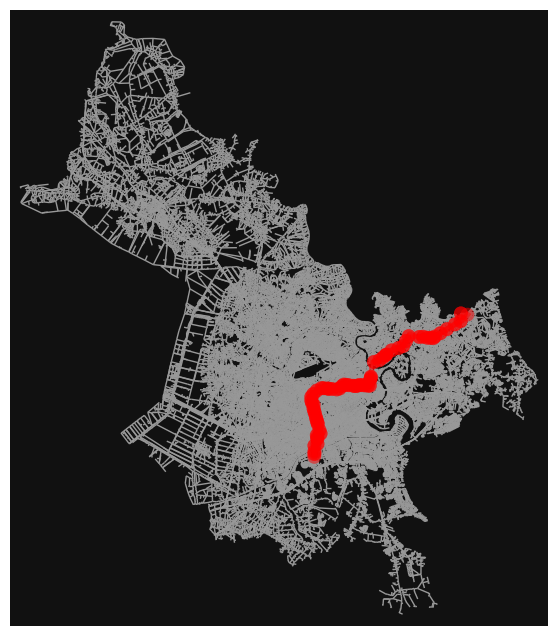

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [71]:
ox.plot_graph_routes(G, stations["routes"], node_size=0, edge_linewidth=1)

In [72]:
routes = stations["routes"]
route_map = ox.plot_route_folium(G, routes[0], None, route_color="#ff0000", tiles="openstreetmap")
for route in routes[1:]:
    try: ox.plot_route_folium(G, route, route_map, route_color="#0000ff", tiles="openstreetmap")
    except: continue
route_map